In [1]:
import numpy as np
import sys
import gsw
import xarray as xr
import numpy as np
from scipy import integrate
import scipy.interpolate as si
from copy import deepcopy 
import matplotlib.pyplot as plt
%matplotlib inline
import cartopy
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib as mpl
from xgcm import Grid 
import warnings
warnings.filterwarnings('ignore')
sys.path.append('/Users/jakesteinberg/ECCOv4-py/ECCOv4-py')
import ecco_v4_py as ecco

In [2]:
# constants 
g = 9.81 
rho0 = 1035

In [3]:
# -- ECCO GRIDS -- 
# base_dir = '/home/username/'
base_dir = '/Users/jakesteinberg/Documents/NASA_OSTST/ECCO/'
## define a high-level directory for ECCO fields
ECCO_dir = base_dir + '/v5'
## Load the model grid
grid_dir= ECCO_dir + '/nctiles_grid/'
# ecco_grid = ecco.load_ecco_grid_nc(grid_dir, 'ECCOv4r3_grid.nc', k_subset=[0])
ecco_grid = ecco.load_ecco_grid_nc(grid_dir, 'ECCO-GRID.nc')

# bathymetry
tile_num=10
lon_range = [-98, -78]; lat_range = [17, 31] 
lons = ecco_grid.XC.sel(tile=tile_num)
lats = ecco_grid.YC.sel(tile=tile_num)
dep = ecco_grid.Depth
dep = dep.where(ecco_grid.hFacC.isel(tile=tile_num,k=0) !=0, np.nan).isel(tile=tile_num)

In [4]:
# mask at the surface and total ocean area 
ocean_mask = np.ceil(ecco_grid.hFacC[0])
ocean_mask = ocean_mask.where(ocean_mask==1, np.nan)
total_ocean_area = np.sum(ecco_grid.rA*ocean_mask)

In [5]:
# -- Gulf of Mexico Mask -- 
ocean_mask = np.ceil(ecco_grid.hFacC[0])
ocean_mask = ocean_mask.where(ocean_mask==1, np.nan)
gulf_mask = xr.DataArray(
    data=ocean_mask.isel(tile=tile_num),
    dims=["j", "i"],
    coords=dict(
        i=(["i"], ecco_grid.XC.i.data), j=(["j"], ecco_grid.XC.j.data),
        XC=(["j","i"], ecco_grid.XC.isel(tile=tile_num).data), YC=(["j","i"], ecco_grid.YC.isel(tile=tile_num).data), 
    ),
)
lon_w = -98; lon_e = -80; 
lat_s = 17; lat_n = 31; 
gulf_mask = gulf_mask.where(lons > lon_w, np.nan)
gulf_mask = gulf_mask.where(lons < lon_e, np.nan)
gulf_mask = gulf_mask.where(lats > lat_s, np.nan)
gulf_mask = gulf_mask.where(lats < lat_n, np.nan)
# subdivisions 
sub1 = np.where((lons > -81.75) & (lats > 25))
gulf_mask[np.arange(sub1[0][0],sub1[0][-1]), np.arange(sub1[1][0],sub1[1][-1])] = np.nan
gulf_mask = gulf_mask.where(lons < -81, np.nan)
sub2 = np.where((lons > -88) & (lats < 21.85))
gulf_mask[np.arange(sub2[0][0],sub2[0][-1]), np.arange(sub2[1][0],sub2[1][-1])] = np.nan
sub3 = np.where((lons > -84) & (lats < 23))
gulf_mask[np.arange(sub3[0][0],sub3[0][-1]), np.arange(sub3[1][0],sub3[1][-1])] = np.nan

In [6]:
gulf_area = np.nansum(gulf_mask*ecco_grid.rA.isel(tile=tile_num))

In [7]:
# surface and layer areas 
h = dep                                               # depth 
A = ecco_grid.rA.isel(tile=tile_num)*gulf_mask        # cell area 
As = gulf_area 
# take layers as cell thicknesses 
imast = ecco_grid.drF.data.cumsum()[0:45]
# loop over each layer and compute area 
AA = []
for i in range(len(imast)):
    AA.append(np.nansum(A.where(h <= imast[i], np.nan)))    # area where depth less than or equal to current depth 
# turn into array 
AAi = np.array([AA.copy()])
AAi[0,0] = As                                               # first value is surface area 
AAi[0,1:] = As - np.array([AA[0:-1]])                       # area in layer i is total area minus area of depths shallower than i 
ii = imast
pbdeps = imast                                              # depths at bottom of each cell 

AAi = xr.DataArray(data=AAi[0,:], dims=["layer"],
    coords=dict(layer=(["layer"], np.arange(0,len(pbdeps))),),
)
print('percent of total area for each layer ' + str(np.round(100*(AAi.data/gulf_area),1)))

percent of total area for each layer [100.   96.4  91.3  86.6  82.5  78.7  75.7  74.2  72.9  72.   71.4  70.4
  69.5  69.   68.3  68.3  67.   66.4  65.2  64.4  63.6  62.7  61.8  61.2
  60.3  59.3  58.   56.6  55.5  53.9  52.2  50.5  49.1  47.9  46.4  44.3
  42.4  40.6  37.2  34.8  32.2  28.3  23.8  12.7   0.1]


In [8]:
# -- Roemmich and Gilson Argo (load climatology just to check ... need to recalculate below) 
filename = ('/Users/jakesteinberg/Documents/CPT/Argo/Argo_potential_density_0_400m.nc')
argo_rho = xr.open_dataset(filename)
RGdensity = argo_rho['density'].data
RGlon = argo_rho.lon.longitude.data
RGlat = argo_rho.lat.latitude.data
RGpressure = argo_rho.pressure.pressure.data
# shift RG by longitude 
RG_shift = np.where(RGlon > 360)[0]
RGlon = np.concatenate((np.arange(0.5,20.5,1), RGlon[0:RG_shift[0]]))
RGdensity = np.concatenate((RGdensity[:,:,:,RG_shift], RGdensity[:,:,:,0:RG_shift[0]]), axis=3)

In [31]:
# TOPOLOGY testing 
filename = ('/Users/jakesteinberg/Documents/topology/aviso_sla_u_v_2021_03_01.nc')
testa = xr.open_dataset(filename)

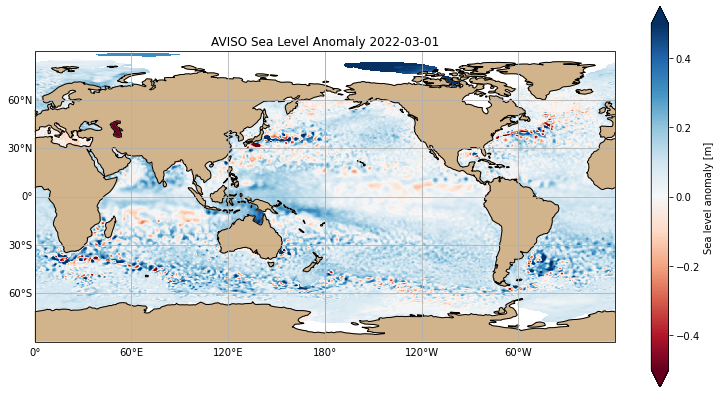

In [42]:
f, ax = plt.subplots(1,1,figsize=(13,7), subplot_kw={'projection':ccrs.PlateCarree(central_longitude=180)})

# data_coords = {'latitude': RGlat, 'longitude': RGlon}
# arg_d = xr.DataArray(data=RGdensity[0][0], dims=['latitude', 'longitude'], coords=data_coords) 
# arg_d_p = arg_d.plot(ax=ax,transform=ccrs.PlateCarree(), vmin=21, vmax=27, \
#                      cmap=plt.get_cmap('jet'), zorder=0, add_colorbar=False) # norm=LogNorm(vmin=pe_levs[0], vmax=pe_levs[1])
# ax.contour(lons,lats,dep,levels=[150],colors='b')
# ax.contour(lons,lats,dep,levels=[1000],colors='k')

tests = testa.sla[1]
tests.plot(ax=ax,transform=ccrs.PlateCarree(), vmin=-0.5, vmax=0.5, cmap=plt.get_cmap('RdBu'))
ax.set_title('AVISO Sea Level Anomaly 2022-03-01')

ax.add_feature(cartopy.feature.LAND, color='#D2B48C',zorder=1); ax.coastlines()
gl = ax.gridlines(draw_labels=True); gl.xlabels_top = False; gl.ylabels_right = False;

# ax.set_xlim([-98,-81]); ax.set_ylim([18,31]);
# ax.set_title('RG Climatology GOM Extent (Jan. surface density)',fontsize=15)
# cbpos = [0.90, 0.13, 0.015, 0.5]; cax = f.add_axes(cbpos); 
# cb = f.colorbar(arg_d_p, cax=cax, orientation='vertical', extend='both', label=r'$\sigma$ [kg m$^{-3}$]')
# f.savefig('/Users/jakesteinberg/Documents/NASA_OSTST/meetings/2022_03_30/GOM_argo_1000m.jpg', dpi=250)
# f.savefig('/Users/jakesteinberg/Documents/topology/aviso_sla_2022_03_01.jpg', dpi=350)

In [10]:
# calculate in situ density 
f_argo_s = '/Users/jakesteinberg/Documents/CPT/Argo/RG_climatology/RG_ArgoClim_Salinity_2019.nc'
f_argo_t = '/Users/jakesteinberg/Documents/CPT/Argo/RG_climatology/RG_ArgoClim_Temperature_2019.nc'
argo_s = xr.open_dataset(f_argo_s,decode_times=False)
argo_t = xr.open_dataset(f_argo_t,decode_times=False)
A_lon = argo_s.LONGITUDE.data
A_lat = argo_s.LATITUDE.data
A_s = argo_s.ARGO_SALINITY_MEAN + argo_s.ARGO_SALINITY_ANOMALY
A_t = argo_t.ARGO_TEMPERATURE_MEAN + argo_t.ARGO_TEMPERATURE_ANOMALY

In [28]:
# shift RG by longitude 
RG_shift = np.where(A_lon > 360)[0]
RG_lon = np.concatenate((np.arange(0.5,20.5,1), A_lon[0:RG_shift[0]]))
RG_S = np.concatenate((A_s[:,:,RG_shift,:], A_s[:,:,0:RG_shift[0],:]), axis=2)
RG_T = np.concatenate((A_t[:,:,RG_shift,:], A_t[:,:,0:RG_shift[0],:]), axis=2)
RG_lon[RG_lon > 180] = RG_lon[RG_lon > 180] - 360 
RG_lat = A_lat
# subset domain 
lon_range = [-98,-81]; lat_range = [18,31];
lon_i = np.where((RG_lon >= lon_range[0]) & (RG_lon <= lon_range[1]))[0]
lat_i = np.where((RG_lat >= lat_range[0]) & (RG_lat <= lat_range[1]))[0]

In [9]:
# in-situ density 
density = np.nan * np.ones((len(A_s.TIME),len(A_s.PRESSURE),len(A_s.LATITUDE[lat_i]),len(A_s.LONGITUDE[lon_i])))
for m in range(len(A_s.TIME)):                       # month 
    for i in range(len(lat_i)):                      # lat
        for j in range(len(lon_i)):                  # lon
            sa_p = gsw.SA_from_SP(RG_S[:,lat_i[i],lon_i[j],m], A_s.PRESSURE.data, RG_lon[lon_i[j]], RG_lat[lat_i[i]])
            ct_p = gsw.CT_from_t(sa_p, RG_T[:,lat_i[i],lon_i[j],m], A_s.PRESSURE.data)
            density[m,:,i,j] = gsw.density.rho(sa_p, ct_p, A_s.PRESSURE.data)
    # print(str(m/len(A_s.TIME)))
# --- density save file ---
data_coords = {'month': A_s.TIME.data, 'p': A_s.PRESSURE.data, 'latitude': RG_lat[lat_i], 'longitude': RG_lon[lon_i]}
da = xr.DataArray(data=density, dims=['month','p','latitude', 'longitude'], coords=data_coords) 
filename = ('/Users/jakesteinberg/Documents/NASA_OSTST/Argo_RG/rho_0_2000m.nc')
da.to_netcdf(path=filename)

In [8]:
# -- load above -- 
filename = ('/Users/jakesteinberg/Documents/NASA_OSTST/Argo_RG/rho_0_2000m.nc')
argo_rho = xr.open_dataset(filename)
RGdensity = argo_rho.__xarray_dataarray_variable__
RGlon = argo_rho.longitude
RGlat = argo_rho.latitude
RGpressure = argo_rho.p
RGz = gsw.z_from_p(RGpressure,np.nanmean(RGlat))

In [13]:
# -- contruct time record 
mo_rec = np.arange(0.5,180.5,1)
t_rec = []; t_start = np.datetime64('2004-01-01')
for i in range(np.shape(RGdensity)[0]):
    t_year = np.floor(A_s.TIME.data[i]/12) + 2004
    t_month = np.floor(np.mod(A_s.TIME.data[i],12)) + 1
    if t_month < 10:
        t_rec.append(np.datetime64(str(np.int(t_year)) + '-0' + str(np.int(t_month)) + '-15'))
    else:
        t_rec.append(np.datetime64(str(np.int(t_year)) + '-' + str(np.int(t_month)) + '-15'))

In [14]:
# deepest check 
test_plot = RGdensity.isel(month=0); deep = np.nan*np.ones((len(test_plot.latitude), len(test_plot.longitude)))
for i in range(len(test_plot.latitude)):
    for j in range(len(test_plot.longitude)):
        i_0 = np.where(test_plot[:,i,j] == np.nanmax(test_plot[:,i,j]))[0]
        if len(i_0) > 0:
            deep[i,j] = RGz[i_0]

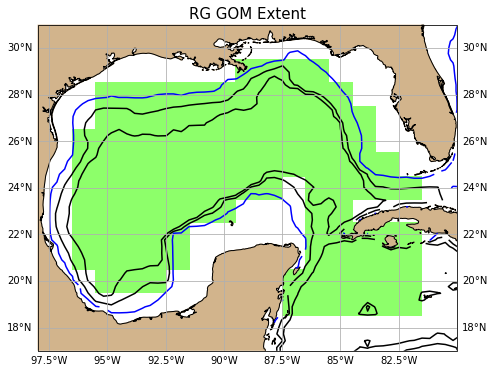

In [96]:
f, ax = plt.subplots(1,1,figsize=(10,6), subplot_kw={'projection':ccrs.PlateCarree(central_longitude=0)})
# arg_d_p = RGdensity.isel(month=0,p=10).plot(ax=ax,transform=ccrs.PlateCarree(), vmin=1021, vmax=1027, \
#                      cmap=plt.get_cmap('jet'), zorder=0, add_colorbar=False) # norm=LogNorm(vmin=pe_levs[0], vmax=pe_levs[1])
arg_d_p = ax.pcolor(RGlon,RGlat,deep,transform=ccrs.PlateCarree(), vmin=-1200, vmax=-800, cmap=plt.get_cmap('jet'))
ax.contour(lons,lats,dep,levels=[150],colors='b')
ax.contour(lons,lats,dep,levels=[1000],colors='k')
ax.contour(lons,lats,dep,levels=[2000],colors='k')
ax.add_feature(cartopy.feature.LAND, color='#D2B48C',zorder=1); ax.coastlines()
gl = ax.gridlines(draw_labels=True); gl.xlabels_top = False;
ax.set_xlim([-98,-80]); ax.set_ylim([17,31]);
ax.set_title('RG GOM Extent',fontsize=15)
# cbpos = [0.90, 0.13, 0.015, 0.5]; cax = f.add_axes(cbpos); 
# cb = f.colorbar(arg_d_p, cax=cax, orientation='vertical', extend='both', label=r'$\sigma$ [kg m$^{-3}$]')
f.savefig('/Users/jakesteinberg/Documents/NASA_OSTST/meetings/2022_04_20/GOM_argoRG_extent.jpg', dpi=250)

In [16]:
# place argo onto ecco vertical grid 
v_cell_t = ecco_grid.hFacC.isel(tile=tile_num)*ecco_grid.drF            # actual layer thicknesses 
v_cell_t = v_cell_t.rename({'k': 'layer'})
v_cell_t = v_cell_t*gulf_mask
# v_cell_z = np.cumsum(ecco_grid.drF.data)[0:36]                          # cumulative sum --> layer depths [0-~1900m]
v_cell_z = ecco_grid.Z                                                  # depth of vertical cell center 

In [17]:
f_d = si.interp1d(-1*RGz,RGdensity,axis=1)
density_eg = f_d(-1*v_cell_z[0:37])

In [18]:
# print(lons[105,230].data); print(lats[105,230].data);
# print(RGlon[5].data); print(RGlat[6].data); 

In [19]:
v_cell_t_argo = xr.DataArray(v_cell_t[0:37][:,105,230])
v_cell_t_argo = v_cell_t_argo*xr.DataArray(np.ones([len(RGlat),len(RGlon)]), dims=('j','i'))
v_cell_z = v_cell_z[0:37]

In [71]:
# data_coords = {'month': np.arange(0,np.shape(density_eg)[0]), 'layer': v_cell_z[0:37].data, \
#                'j': RGlat.data, 'i': RGlon.data}
# den_eg_da = xr.DataArray(data=density_eg, dims=['month','layer','j', 'i'], coords=data_coords) 

den_eg_da = xr.Dataset(
    data_vars=dict(
        rho=(['month','layer','j', 'i'], density_eg),
        v_cell_thick=(['layer','j','i'], v_cell_t_argo.data),
        AAi_Argo=(['layer'], AAi[0:37].data),
        time=(['month'], t_rec)
    ),
    coords=dict(
        i=(["i"], np.arange(0,len(RGlon.data))), 
        j=(["j"], np.arange(0,len(RGlat.data))),
        month=(["month"], np.arange(0,np.shape(density_eg)[0])),
        # time=(["date"], t_rec),
        layer=(["layer"], np.arange(0,len(v_cell_z.data)))
    ),
)

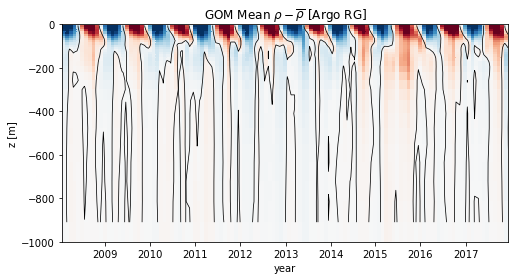

In [94]:
den_RG = xr.DataArray(data=den_eg_da.rho.mean(dim=['j','i']).data, dims=["time","zi"],
                        coords=dict(zi=(["zi"], v_cell_z.data), time=(["time"], den_eg_da.time.data),
                        ),
                       )
t_s = '2008-01-15'
t_e = '2017-12-15'
rho_argo = den_RG.sel(time=slice(t_s, t_e))
f, ax = plt.subplots(1,1,figsize=(8,4))
pp = ax.pcolor(rho_argo.time,v_cell_z,(rho_argo - rho_argo.mean(dim='time')).transpose(), cmap='RdBu', vmin=-0.75, vmax=0.75)
ax.contour(rho_argo.time,v_cell_z,(rho_argo - rho_argo.mean(dim='time')).transpose(), levels=[0], colors='k', linewidths=0.75)
ax.set_title(r'GOM Mean $\rho - \overline{\rho}$ [Argo RG]')
ax.set_ylabel('z [m]'); ax.set_xlabel('year'); # ax.set_xlim([t_s, t_e])
ax.set_ylim([-1000,0])
# cbpos = [0.93, 0.18, 0.015, 0.5]; cax = f.add_axes(cbpos); 
# cb = f.colorbar(pp, cax=cax, orientation='vertical', extend='both', label=r'kg m$^{-3}$')
f.savefig('/Users/jakesteinberg/Documents/NASA_OSTST/meetings/2022_04_20/GOM_argoRG_rho_pr.jpg', dpi=250)

In [21]:
# -- Run Landerer Model -- 
delta_pb_total = np.nan*np.ones((np.shape(density_eg)[0],np.shape(density_eg)[1]))
lay1 = np.nan*np.ones((np.shape(density_eg)[0]))
layb = np.nan*np.ones((np.shape(density_eg)[0],len(v_cell_z)-1))
for tt in range(np.shape(density_eg)[0]):                               # loop over all times 
    for m in range(0,29):                                               # loop over all layers 
        this_i = np.where(-1*v_cell_z <= -1*v_cell_z[m])[0]             # all depths shallower than depth i 
        this_i = this_i[-1]                                             # deepest index (the layer we care about in this loop)
    
        below_i = np.arange(this_i+1,len(v_cell_z))
        above_i = np.arange(0,this_i+1)
    
        # -- for each layer, multiply rho_prime by layer thickness, then average across basin 
        below = (1/rho0)*( (den_eg_da.AAi_Argo.isel(layer=below_i)/As)*\
                           (den_eg_da.v_cell_thick.isel(layer=below_i)*\
                           -1*den_eg_da.rho.isel(month=tt,layer=below_i)).mean(dim=['j','i'])).sum(dim='layer')
        above = (1/rho0)*((As/den_eg_da.AAi_Argo.isel(layer=above_i) - 1)*(den_eg_da.AAi_Argo.isel(layer=above_i)/As)*\
                           (den_eg_da.v_cell_thick.isel(layer=above_i)*\
                           -1*den_eg_da.rho.isel(month=tt,layer=above_i)).mean(dim=['j','i'])).sum(dim='layer')
        delta_pb_total[tt,m] = below.data - above.data
        
    # -- consider individual output contributions ONLY to layer 1
    m = 0
    this_i = np.where(-1*v_cell_z <= -1*v_cell_z[m])[0]             # all depths shallower than depth i 
    this_i = this_i[-1]                                             # deepest index (the layer we care about in this loop)
    below_i = np.arange(this_i+1,len(v_cell_z))
    above_i = np.arange(0,this_i+1)
    above_1 = (1/rho0)*((As/den_eg_da.AAi_Argo.isel(layer=above_i) - 1)*(den_eg_da.AAi_Argo.isel(layer=above_i)/As)*\
                      (den_eg_da.v_cell_thick.isel(layer=above_i)*\
                       -1*den_eg_da.rho.isel(month=tt,layer=above_i)).mean(dim=['j','i'])).sum(dim='layer')
    below_1 = (1/rho0)*( (den_eg_da.AAi_Argo.isel(layer=below_i)/As)*\
                           (den_eg_da.v_cell_thick.isel(layer=below_i)*\
                           -1*den_eg_da.rho.isel(month=tt,layer=below_i)).mean(dim=['j','i']) ) # .sum(dim='layer')
    # below should have dimensions len(v_cell_z) - 1
    # above should have dimensions 1x1 
    lay1[tt] = above_1.data 
    layb[tt,:] = below_1.data
    
    

# output as data array 
deltapbz_total = xr.DataArray(data=np.transpose(delta_pb_total), dims=["zi","time"],
                        coords=dict(
                            zi=(["zi"], v_cell_z.data),
                            time=(["time"], den_eg_da.time.data),
                        ),
                       )

In [22]:
# -- reference MLD changes ARGO
f_argo_mld = '/Users/jakesteinberg/Documents/CPT/Argo/Argo_mixedlayers_monthlyclim_12112019.nc'
argo_mld = xr.open_dataset(f_argo_mld)
mld_lon = argo_mld['lon'].data
mld_lat = argo_mld['lat'].data
# subset domain 
mld_lon_i = np.where((mld_lon >= lon_range[0]) & (mld_lon <= lon_range[1]))[0]
mld_lat_i = np.where((mld_lat >= lat_range[0]) & (mld_lat <= lat_range[1]))[0]
# mld_mo = argo_mld['month'].data
mld = argo_mld['mld_dt_mean'].data[mld_lat_i][:,mld_lon_i]

(-1000.0, 0.0)

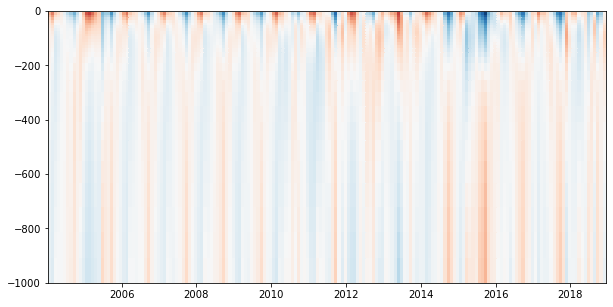

In [100]:
test = deltapbz_total - deltapbz_total.mean(dim=['time'])
f, ax = plt.subplots(1,1,figsize=(10,5))
ax.pcolor(deltapbz_total.time,v_cell_z,test.data, cmap='RdBu', vmin=-0.1, vmax=0.1)
ax.set_ylim([-1000,0])

In [104]:
# -- remove time mean from landerer predicted delta pb and fit linear trend at each depth 
# choose years to fit over # --- deltapbz_total.sel(time=slice('2008-01-15', '2017-12-15')) --- 
t_s = '2008-01-15'
t_e = '2017-12-15'
test = (deltapbz_total.sel(time=slice(t_s, t_e)) - deltapbz_total.sel(time=slice(t_s, t_e)).mean(dim=['time']))
p_test = test.polyfit(dim='time', deg=1)
p_test = (p_test.isel(degree=0).polyfit_coefficients)*1e9*60*60*24*365

t_s2 = '2010-01-15'
t_e = '2017-12-15'
test2 = (deltapbz_total.sel(time=slice(t_s2, t_e)) - deltapbz_total.sel(time=slice(t_s2, t_e)).mean(dim=['time']))
p_test2 = test2.polyfit(dim='time', deg=1)
p_test2 = (p_test2.isel(degree=0).polyfit_coefficients)*1e9*60*60*24*365

In [28]:
tg_mvlm = np.array([0.00112159, 0.01565987,0.00963731,0.00708055,0.01110867,0.00458044, \
           0.01084324,0.01014648,0.00931487,0.00945693,0.00602123,-0.05283225, \
           -0.04994991, -0.04706447, -0.02501843, 0.02592018, -0.01980905, -0.02196808, \
           -0.02537979])
av_sla = np.array([0.01034107, 0.01264219, 0.01273066, 0.0122491 , 0.01237314,
       0.01134915, 0.0118723 , 0.01213805, 0.01113358, 0.01123332,
       0.00998862, 0.01231523, 0.01296707, 0.01219524, 0.01272233,
       0.01314011, 0.01330125, 0.01290779, 0.01494085])

In [ ]:
# for aviso sla should remove basin mean obp trend 

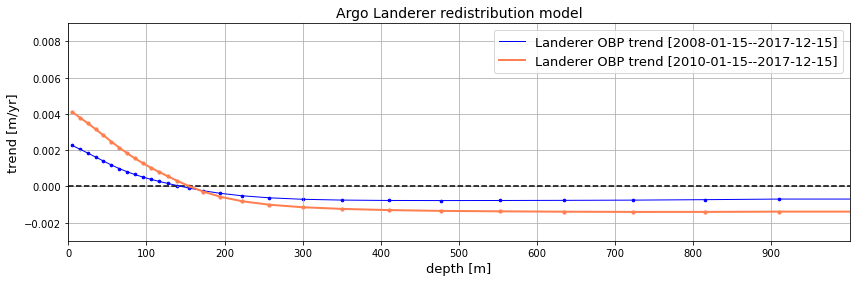

In [107]:
f,ax = plt.subplots(1,1,figsize=(14,4))
ax.plot([0,3000],[0, 0], color='k', linewidth=1.5, linestyle='--')
# ax.scatter(dep.isel(tile=tile_num)*gulf_mask, gulf_a_obp, s=10, color='#708090',label='obp trend'); 

ax.plot(-1*v_cell_z.data, p_test, color='b', linewidth=1, label='Landerer OBP trend [' + t_s + '--' + t_e + ']')
ax.scatter(-1*v_cell_z.data, p_test, color='b', s=7)
ax.plot(-1*v_cell_z.data, p_test2, color='#FF7F50', linewidth=2, label='Landerer OBP trend [' + t_s2 + '--' + t_e + ']')
ax.scatter(-1*v_cell_z.data, p_test2, color='#FF7F50', s=10)

# ax.scatter(5*np.ones(len(tg_mvlm)),tg_mvlm, color='b', s=10)

ax.set_xlim([0,1000]); ax.set_xticks(np.arange(0,1000,100)); ax.set_xlabel('depth [m]',fontsize=13)
ax.set_ylabel('trend [m/yr]',fontsize=13); ax.set_ylim([-0.003, 0.009]);
ax.grid(); ax.set_title('Argo Landerer redistribution model',fontsize=14); ax.legend(fontsize=13)
f.savefig('/Users/jakesteinberg/Documents/NASA_OSTST/meetings/2022_04_20/GOM_argo_landerer.jpg', dpi=250)

In [214]:
lay1_da = xr.DataArray(data=lay1, dims=["time"],
                        coords=dict(time=(["time"], den_eg_da.time.data)),
                       )
layb_da = xr.DataArray(data=np.transpose(layb), dims=["zi","time"],
                        coords=dict(
                            zi=(["zi"], v_cell_z.data[1:]),
                            time=(["time"], den_eg_da.time.data)),
                       )

In [216]:
test1_time = den_eg_da.time.data
test1 = lay1_da.sel(time=slice(t_s, t_e))
testb = layb_da.sel(time=slice(t_s, t_e))
layerbylayer = testb.cumsum(dim='zi') - test1
layerbylayer_a = layerbylayer - layerbylayer.mean(dim=['time'])
p1_test = layerbylayer_a.polyfit(dim='time', deg=1)
p1_test = (p1_test.isel(degree=0).polyfit_coefficients)*1e9*60*60*24*365

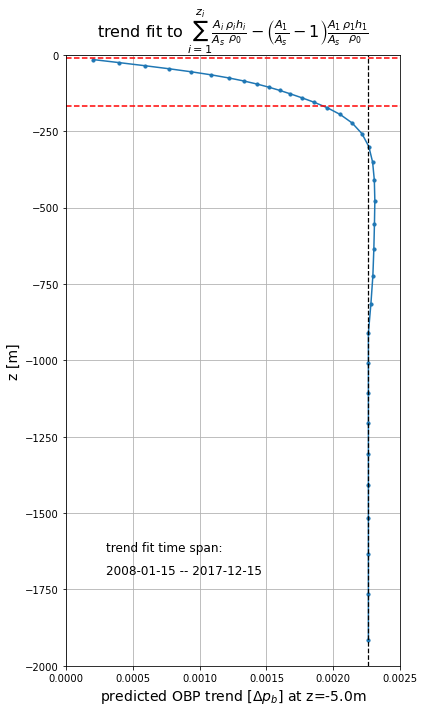

In [292]:
# contributions to layer 1 
f, ax = plt.subplots(1,1,figsize=(6,10))
ax.plot(p1_test,v_cell_z[1:],linewidth=1.5); ax.scatter(p1_test,v_cell_z[1:],s=10)
ax.plot([p_test[0],p_test[0]],[-2000,0],linestyle='--',color='k',linewidth=1.25)
ax.plot([0,0.003],[-1*np.nanmax(mld),-1*np.nanmax(mld)],linestyle='--',color='r')
ax.plot([0,0.003],[-1*np.nanmin(mld),-1*np.nanmin(mld)],linestyle='--',color='r')
ax.grid(); ax.set_xlabel(r'predicted OBP trend [$\Delta p_b$] at z='+str(v_cell_z[0].data)+'m',fontsize=14)
ax.set_ylabel('z [m]',fontsize=14)
ax.set_title(r'trend fit to $\sum_{i=1}^{z_i} \frac{A_i}{A_s} \frac{\rho_i h_i}{\rho_0} - \left(\frac{A_1}{A_s} - 1 \right) \frac{A_1}{A_s} \frac{\rho_1 h_1}{\rho_0}$',\
            fontsize=16)
ax.text(0.0003,-1625,'trend fit time span:',fontsize=12)
ax.text(0.0003,-1700,'2008-01-15 -- 2017-12-15',fontsize=12)
ax.set_ylim([-2000,0]); ax.set_xlim([0,0.0025])
f.tight_layout()
f.savefig('/Users/jakesteinberg/Documents/NASA_OSTST/meetings/2022_04_08/GOM_argo_lay1_contributions.jpg', dpi=250)

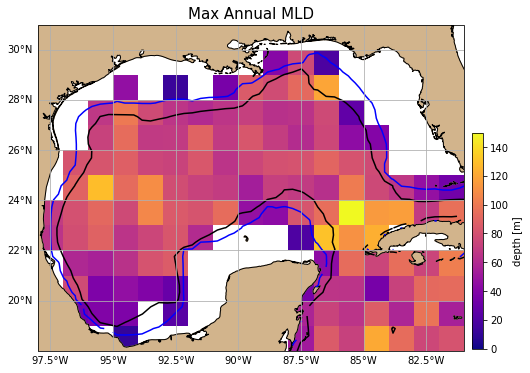

In [291]:
# MLD variability 
data_coords = {'latitude': mld_lat[mld_lat_i], 'longitude': mld_lon[mld_lon_i]}
f, ax = plt.subplots(1,1,figsize=(10,6), subplot_kw={'projection':ccrs.PlateCarree(central_longitude=0)})
arg_d = xr.DataArray(data=np.nanmax(mld,axis=2), dims=['latitude', 'longitude'], coords=data_coords) 
arg_d_p = arg_d.plot(ax=ax,transform=ccrs.PlateCarree(), vmin=0, vmax=150, \
                     cmap=plt.get_cmap('plasma'), zorder=0, add_colorbar=False) # norm=LogNorm(vmin=pe_levs[0], vmax=pe_levs[1])
ax.contour(lons,lats,dep,levels=[150],colors='b')
ax.contour(lons,lats,dep,levels=[1000],colors='k')
ax.add_feature(cartopy.feature.LAND, color='#D2B48C',zorder=1); ax.coastlines()
gl = ax.gridlines(draw_labels=True); gl.xlabels_top = False; gl.ylabels_right = False;
ax.set_xlim([-98,-81]); ax.set_ylim([18,31]);
ax.set_title('Max Annual MLD',fontsize=15)
cbpos = [0.82, 0.13, 0.015, 0.5]; cax = f.add_axes(cbpos); 
cb = f.colorbar(arg_d_p, cax=cax, orientation='vertical', label=r'depth [m]')
f.savefig('/Users/jakesteinberg/Documents/NASA_OSTST/meetings/2022_04_08/GOM_argo_mld_max.jpg', dpi=250)